## 1. Environment Setup

### 1.1 Change Directory

Use jupyter magic command `%cd` to change the directory to the root directory of the project

In [1]:
%cd ../

/Users/joye/Github/datawhale_team_learning/projects/202301_image_classification


### 1.2 Install Packages

Install the packages with `pip`:
- `-r` means instaling from requirements.txt
- `-q` means installing quitely

In [2]:
!pip install -q -r requirements.txt

## 2. Download Images for Inference

In [3]:
%%bash
zhihao_asset="https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification"
data_dir="data/image_net"

curl $zhihao_asset/dataset/meta_data/imagenet_class_index.csv -o $data_dir/meta_data/class_index.csv --create-dirs 

curl $zhihao_asset/test/watermelon1.jpg -o $data_dir/test/watermelon1.jpg --create-dirs 
curl $zhihao_asset/test/banana1.jpg -o $data_dir/test/banana1.jpg --create-dirs 
curl $zhihao_asset/test/cat1.jpg -o $data_dir/test/cat1.jpg --create-dirs 

# husky，source: https://www.pexels.com/zh-cn/photo/2853130/
curl $zhihao_asset/test/husky1.jpeg -o $data_dir/test/husky1.jpeg --create-dirs 

# cat dog，来源：https://unsplash.com/photos/ouo1hbizWwo
curl $zhihao_asset/test/cat_dog.jpg -o $data_dir/test/cat_dog.jpg --create-dirs 

# video
curl $zhihao_asset/test/video_2.mp4 -o $data_dir/test/video_2.mp4 --create-dirs 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37074  100 37074    0     0  85869      0 --:--:-- --:--:-- --:--:-- 89334
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  419k  100  419k    0     0   814k      0 --:--:-- --:--:-- --:--:--  827k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  453k  100  453k    0     0   869k      0 --:--:-- --:--:-- --:--:--  881k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34701  100 34701    0     0    97k      0 --:--:-- --:--:-- --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Tim

## 3. Inference using Pretrained Models(en)

### 3.1 Load Packages and Setup Device

In [4]:
from torchvision import transforms


import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

config = {
"font.family":"serif",
"font.serif":["SimHei"]
}

plt.rcParams.update(config)

# Use GPU if it is available otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
avaliability = "available" if torch.cuda.is_available() else "unavailable"
print(f'GPU is {avaliability} thus using {device.type.upper()}')

# sets the backend of matplotlib to the 'inline' backend, 
# With this backend, the output of plotting commands is displayed 
# inline within frontends like the Jupyter notebook, directly below
# the code cell that produced it. 
# The resulting plots will then also be stored in the notebook document.
%matplotlib inline

GPU is unavailable thus using CPU


### 3.2 Load Pretrained Models

In [5]:
# Import model and pretrained weights
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained image classification models
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# set model to evaluation/inference status
model = model.eval()
# send move to device
model = model.to(device)

### 3.3 Image Preprocessing for Inference

In [6]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
def preprocess(img_path,show_plot = True):
    img_pil = Image.open(img_path)
    print("Before preprocess: ", np.array(img_pil).shape)
    preprocessed_img = test_transform(img_pil) 
    print("After preprocess: ", preprocessed_img.shape)
    
    if show_plot:
        fig = plt.figure(figsize=(18,6))
        # Plot the annonated figure on the right hand-side
        ax1 = plt.subplot(1,2,1)
        ax1.imshow(img_pil)
        ax1.axis('off')
        ax2 = plt.subplot(1,2,2)
        # ax2.imshow(torch.reshape(preprocessed_img,(224,224,3)))
        # ax2.imshow(preprocessed_img.reshape(224,224,3))
        # ax2.imshow(preprocessed_img.permute(2,1,0))
        # ax2.imshow((preprocessed_img.permute(2,1,0).numpy()*255).astype('uint8'))
        p = preprocessed_img.permute(2,1,0).numpy()
        p = p/np.amax(p)
        p = np.clip(p, 0, 1)
        ax2.imshow(p)
        ax2.axis('off')
    return preprocessed_img

Before preprocess:  (820, 1094, 3)
After preprocess:  torch.Size([3, 224, 224])


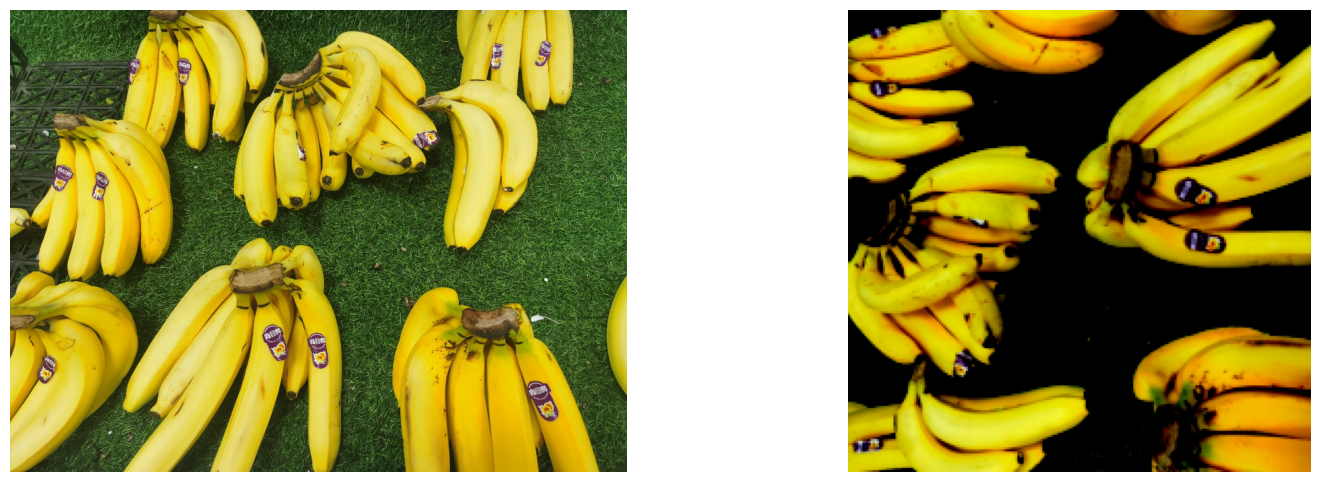

In [7]:
################################################
# parameter
################################################
img_path = 'data/image_net/test/banana1.jpg'
################################################
input_img = preprocess(img_path)

In [8]:
img_pil = Image.open(img_path)

preprocessed_img = test_transform(img_pil) 

### 3.4 Inference 

In [9]:
import torch.nn.functional as F

def inference(input_img):
    input_img = input_img.unsqueeze(0).to(device)
    pred_logits = model(input_img) # Model inference
    print("Run model inference and output logits. The shape is ->", 
          pred_logits.shape)
    # Apply softmax
    pred_softmax = F.softmax(pred_logits, dim=1)
    print("Apply softmax on the logits to get probability. The shape is ->", 
          pred_softmax.shape)
    return pred_softmax

In [10]:
pred_softmax = inference(input_img)

Run model inference and output logits. The shape is -> torch.Size([1, 1000])
Apply softmax on the logits to get probability. The shape is -> torch.Size([1, 1000])


### 3.5 Analysis on Infernce Results

In [11]:
def plot_class_probability(y, bar_label= False,language = 'en'):
    plt.figure(figsize=(8,4))
    
    x = range(y.shape[0])
    ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
    plt.ylim([0, 1.0]) # y axis
    
    if bar_label:
        plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
    
    if language == 'en':
        plt.xlabel('Class', fontsize=10,fontname='Arial')
        plt.ylabel('Confidence', fontsize=10,fontname='Arial')

    else:
        
        plt.xlabel('类别', fontsize=10)
        plt.ylabel('置信度', fontsize=10)
    plt.tick_params(labelsize=10) 
    plt.title(img_path, fontsize=15,fontname='Arial')
    plt.show()

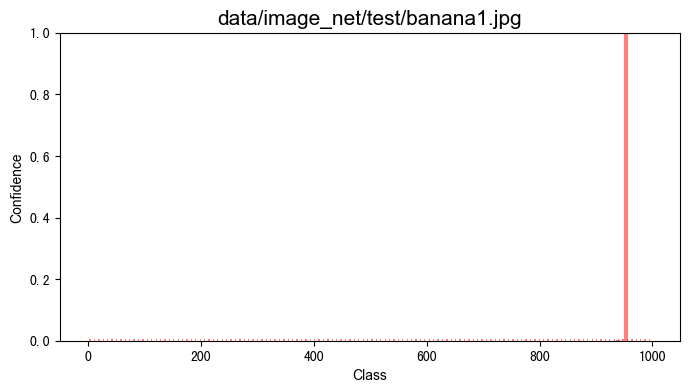

In [12]:
# Returns a copy of this object in CPU memory
y = pred_softmax.cpu().detach().numpy()[0] 
plot_class_probability(y)

### 3.6 Annotate Image with prediction

In [13]:
def get_top_n(pred_softmax,n =10):
    top_n = torch.topk(pred_softmax, n)
    # get the id of top n
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()
    # get the probablity of top n
    confs = top_n[0].cpu().detach().numpy().squeeze()
    return pred_ids, confs

def get_idx_labels(file_path=None,language = 'en'):
    if file_path is None:
        file_path='data/image_net/meta_data/class_index.csv'
    df = pd.read_csv(file_path)
    idx_to_labels = {}
    for idx, row in df.iterrows():
        if language == 'en':
            idx_to_labels[row['ID']] = [row['wordnet'], row['class']]
        else:
            idx_to_labels[row['ID']] = [row['wordnet'], row['Chinese']]
    return idx_to_labels

def annotate_image(img_path, n,file_path=None,language = 'en',save=True):
    # use opencv to load the image
    if language == 'en':
        img = cv2.imread(img_path)
    else:
        img = Image.open(img_path) 
        draw = ImageDraw.Draw(img)
    pred_ids, confs = get_top_n(pred_softmax,n)
    idx_to_labels = get_idx_labels(file_path,language)
    for i in range(n):
        class_name = idx_to_labels[pred_ids[i]][1] # get name of the category 
        confidence = confs[i] * 100 # get probabiliy of the category
        text = '{:<15} {:>.4f}'.format(class_name, confidence)
        # annotate image on its left upper corner 
        # params: location，font，size，bgr color，line width
        if language == 'en':
            img = cv2.putText(img, text, 
                              (25, 50 + 40 * i), 
                              cv2.FONT_HERSHEY_SIMPLEX,
                              1.25, 
                              (0, 0, 255),
                              3)
        else:
            draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    if save:
        if language =='en':
            # save the image to output folder
            _ = cv2.imwrite('output/img_pred.jpg', img)
        else:
            # save the image to output folder
            img.save('output/img_pred.jpg')  
    return img 

In [14]:
annotated_img = annotate_image(img_path, n=10)
# load the predicted image
img_pred = Image.open('output/img_pred.jpg')

In [15]:
def pair_plot(img_path, img_pred,pred_softmax,language='en'):
    fig = plt.figure(figsize=(18,6))
    # Plot the annonated figure on the right hand-side
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(img_pred)
    ax1.axis('off')

    # Plot bar chart for the probability of different classes
    ax2 = plt.subplot(1,2,2)
    file_path='data/image_net/meta_data/class_index.csv'
    df =  pd.read_csv(file_path)
    x = df['ID']
    y = pred_softmax.cpu().detach().numpy()[0]
    ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)

    plt.ylim([0, 1.0]) # y axis range
    if language == 'en':
        plt.title('{} image classification'.format(img_path), fontsize=15,fontname='Arial')
        plt.xlabel('Class', fontsize=10,fontname='Arial')
        plt.ylabel('Confidence', fontsize=10,fontname='Arial')
    else:
        plt.title('{} 图像分类'.format(img_path), fontsize=15)
        plt.xlabel('类别', fontsize=10)
        plt.ylabel('置信度', fontsize=10)
    plt.tick_params(labelsize=10) 
    plt.show()
    plt.tight_layout()
    fig.savefig('output/annonated+prob_bar.jpg')


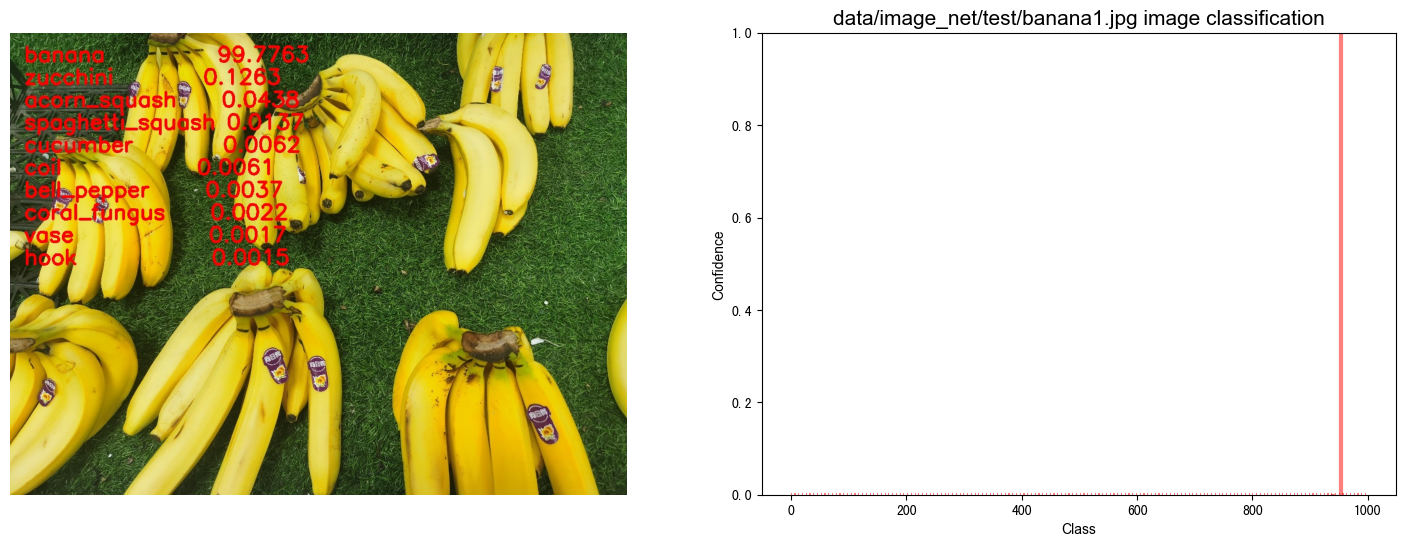

<Figure size 640x480 with 0 Axes>

In [16]:
pair_plot(img_path,img_pred,pred_softmax,language='en')

### 3.7 Table of Probablities of Classes

In [17]:
def prediction(pred_softmax,n=10,language='en'):
    pred_df = pd.DataFrame() 
    idx_to_labels = get_idx_labels(language=language)
    pred_ids, confs = get_top_n(pred_softmax,n)
    for i in range(n):
        class_name = idx_to_labels[pred_ids[i]][1] # Get the class name based on ID
        label_idx = int(pred_ids[i]) # Get the class ID
        wordnet = idx_to_labels[pred_ids[i]][0] # Get WordNet
        confidence = confs[i] * 100 # get probability
        temp = pd.DataFrame([{'Class':class_name, 'Class_ID':label_idx,
                                          'Confidence(%)':confidence, 'WordNet':wordnet}])
    
        pred_df = pd.concat([pred_df,temp])
    return pred_df

In [18]:
display(prediction(pred_softmax)) # display the final prediction

,Class,Class_ID,Confidence(%),WordNet
0,banana,954,99.776316,n07753592
0,zucchini,939,0.126272,n07716358
0,acorn_squash,941,0.043848,n07717410
0,spaghetti_squash,940,0.013670,n07716906
0,cucumber,943,0.006226,n07718472
0,coil,506,0.006063,n03065424
0,bell_pepper,945,0.003749,n07720875
0,coral_fungus,991,0.002227,n12985857
0,vase,883,0.001681,n04522168
0,hook,600,0.001548,n03532672


## 4. Inference using Pretrained Models(zh)

### 4.1 Import Chinese Font for Pillow

Import Chinese font and set font size. The font `SimHei.ttf` was downloaded and save to matplotlib font folder. For details on how to download and save the font, 
please check [notes on task 1]( https://github.com/joyenjoye/datawhale_team_learning/blob/main/projects/202301_image_classification/notebooks/01_data_preparation.ipynb)

In [19]:
from PIL import ImageFont, ImageDraw
env_path = "/usr/local/Caskroom/miniforge/base/envs/joye_env"
font_path = "lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf"
font = ImageFont.truetype(os.path.join(env_path,font_path), 32)

### 4.2 Load Packages and Setup Device

### 4.3 Load Pretrained Models

Before preprocess:  (1560, 2340, 3)
After preprocess:  torch.Size([3, 224, 224])


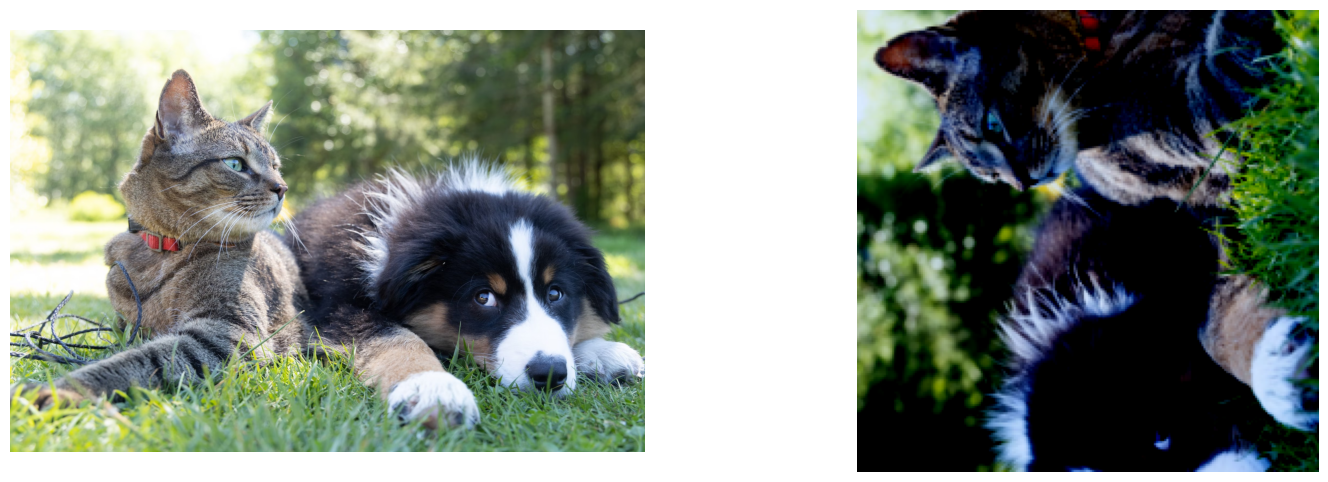

In [20]:
################################################
# parameter
################################################
img_path = 'data/image_net/test/cat_dog.jpg'
################################################
input_img = preprocess(img_path)

### 4.5 Inference 

In [21]:
pred_softmax = inference(input_img)

Run model inference and output logits. The shape is -> torch.Size([1, 1000])
Apply softmax on the logits to get probability. The shape is -> torch.Size([1, 1000])


### 4.6 Analysis on Infernce Results

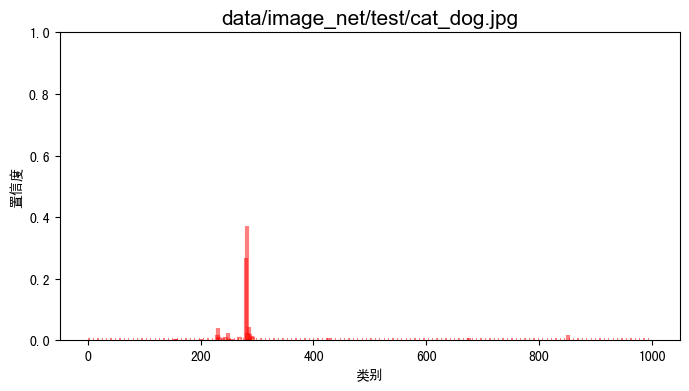

In [22]:
y = pred_softmax.cpu().detach().numpy()[0] 
plot_class_probability(y,language = 'zh')

### 4.7 Annotate Image with Prediction

In [23]:
annotated_img = annotate_image(img_path, n=10,language='zh')
# load the predicted image
img_pred = Image.open('output/img_pred.jpg')

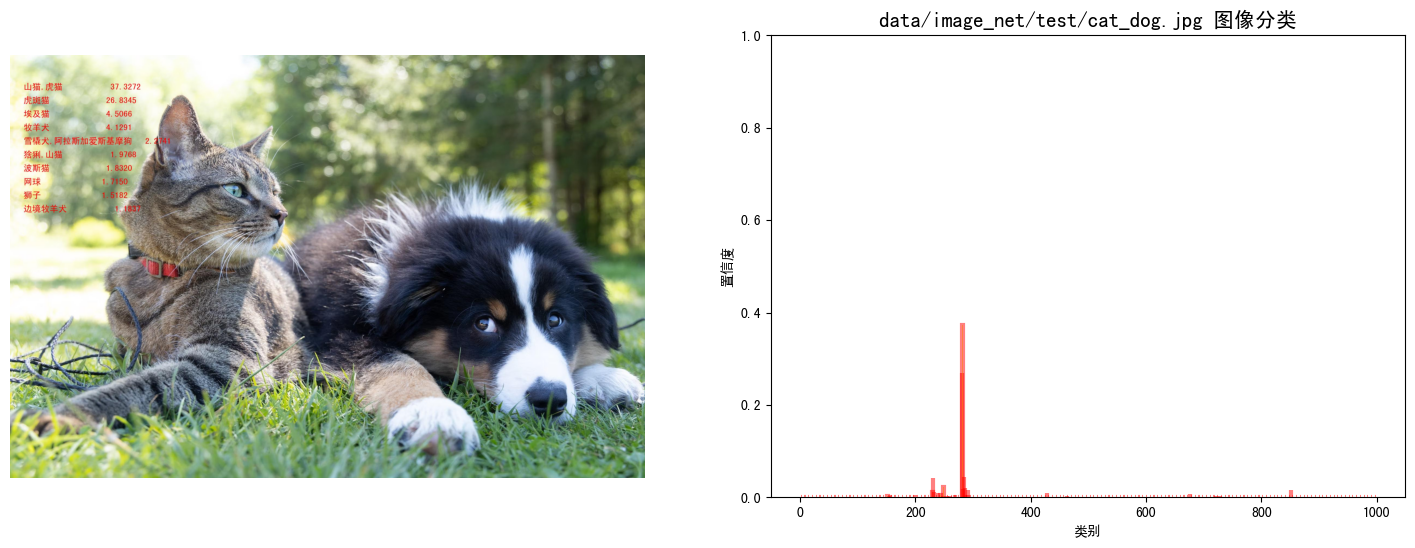

<Figure size 640x480 with 0 Axes>

In [24]:
pair_plot(img_path, img_pred,pred_softmax,language='zh')

### 4.8 Table of Probablities of Classes

In [25]:
display(prediction(pred_softmax,language = 'zh')) 

,Class,Class_ID,Confidence(%),WordNet
0,"山猫,虎猫",282,37.327239,n02123159
0,虎斑猫,281,26.834521,n02123045
0,埃及猫,285,4.506620,n02124075
0,牧羊犬,231,4.129088,n02106030
0,"雪橇犬,阿拉斯加爱斯基摩狗",249,2.274127,n02110063
0,"猞猁,山猫",287,1.976750,n02127052
0,波斯猫,283,1.831976,n02123394
0,网球,852,1.714958,n04409515
0,狮子,291,1.518197,n02129165
0,边境牧羊犬,232,1.183690,n02106166
